In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
path = r'C:\Users\User\dev\training_model\dataset\modified_financial_data.csv'

df = pd.read_csv(path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df.head()

,^GSPC,GLD,USO,SLV,EURUSD=X,Date
0,2058.199951,114.080002,159.119995,15.11,1.208941,2015-01-02
1,2020.579956,115.800003,150.320007,15.50,1.194643,2015-01-05
2,2002.609985,117.120003,144.399994,15.83,1.193902,2015-01-06
3,2025.900024,116.430000,146.960007,15.85,1.187536,2015-01-07
4,2062.139893,115.940002,148.399994,15.64,1.183600,2015-01-08


In [4]:
df = df.rename(columns={"^GSPC": "SPX", "EURUSD=X": "EUR/USD"})
df.head()

,SPX,GLD,USO,SLV,EUR/USD,Date
0,2058.199951,114.080002,159.119995,15.11,1.208941,2015-01-02
1,2020.579956,115.800003,150.320007,15.50,1.194643,2015-01-05
2,2002.609985,117.120003,144.399994,15.83,1.193902,2015-01-06
3,2025.900024,116.430000,146.960007,15.85,1.187536,2015-01-07
4,2062.139893,115.940002,148.399994,15.64,1.183600,2015-01-08


In [19]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD']
target = 'GLD'

split_index = int(len(df) * 0.8)
train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_test = scaler_X.transform(test_df[features])

y_train = scaler_y.fit_transform(train_df[[target]])
y_test = scaler_y.transform(test_df[[target]])


In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
rf_preds = rf.predict(X_test)

In [21]:
def create_sequences(df_seq, features, target_col, n_steps, scaler_X, scaler_y):
    data_scaled = df_seq.copy()
    X_scaled = scaler_X.transform(data_scaled[features])
    y_scaled = scaler_y.transform(data_scaled[[target_col]])

    X_seq, y_seq = [], []
    for i in range(n_steps, len(data_scaled)):
        X_seq.append(X_scaled[i - n_steps:i])
        y_seq.append(y_scaled[i])
    return np.array(X_seq), np.array(y_seq)

In [22]:
n_steps = 10
X_lstm_train, y_lstm_train = create_sequences(train_df, features, target, n_steps, scaler_X, scaler_y)
X_lstm_test, y_lstm_test = create_sequences(test_df, features, target, n_steps, scaler_X, scaler_y)

model_lstm = Sequential([
    LSTM(50, input_shape=(n_steps, len(features))),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=16, verbose=0)

lstm_preds = model_lstm.predict(X_lstm_test).ravel()

c:\Users\User\dev\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [28]:
min_len = min(len(rf_preds), len(lstm_preds))
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]
y_true = y_test[-min_len:].ravel()

#--- adding weights to maodels in ensemble
combined_preds = 0.5 * rf_preds + 0.5 * lstm_preds

meta_X = np.column_stack((rf_preds, lstm_preds))
meta_model = LinearRegression()
meta_model.fit(meta_X, y_true)
final_preds = meta_model.predict(meta_X)

In [29]:
def evaluate_model(name, y_true, preds):
    return {
        'Model': name,
        'R² Score': round(r2_score(y_true, preds), 4),
        'MSE': round(mean_squared_error(y_true, preds), 6)
    }

In [30]:
metrics = [
    evaluate_model("Random Forest", y_true, rf_preds),
    evaluate_model("LSTM", y_true, lstm_preds),
    evaluate_model("Weighted Ensemble", y_true, combined_preds),
    evaluate_model("Stacked Ensemble", y_true, final_preds)
]

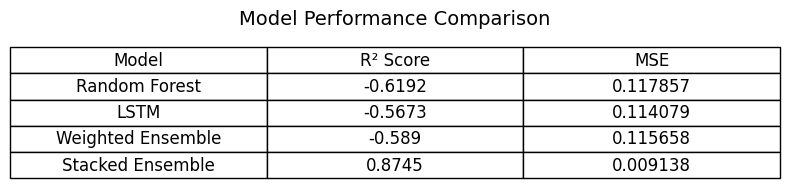

In [31]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table_data = [(m['Model'], m['R² Score'], m['MSE']) for m in metrics]
table = ax.table(cellText=table_data, colLabels=["Model", "R² Score", "MSE"],
                 cellLoc='center', loc='center')
table.scale(1, 2)
table.set_fontsize(12)
plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

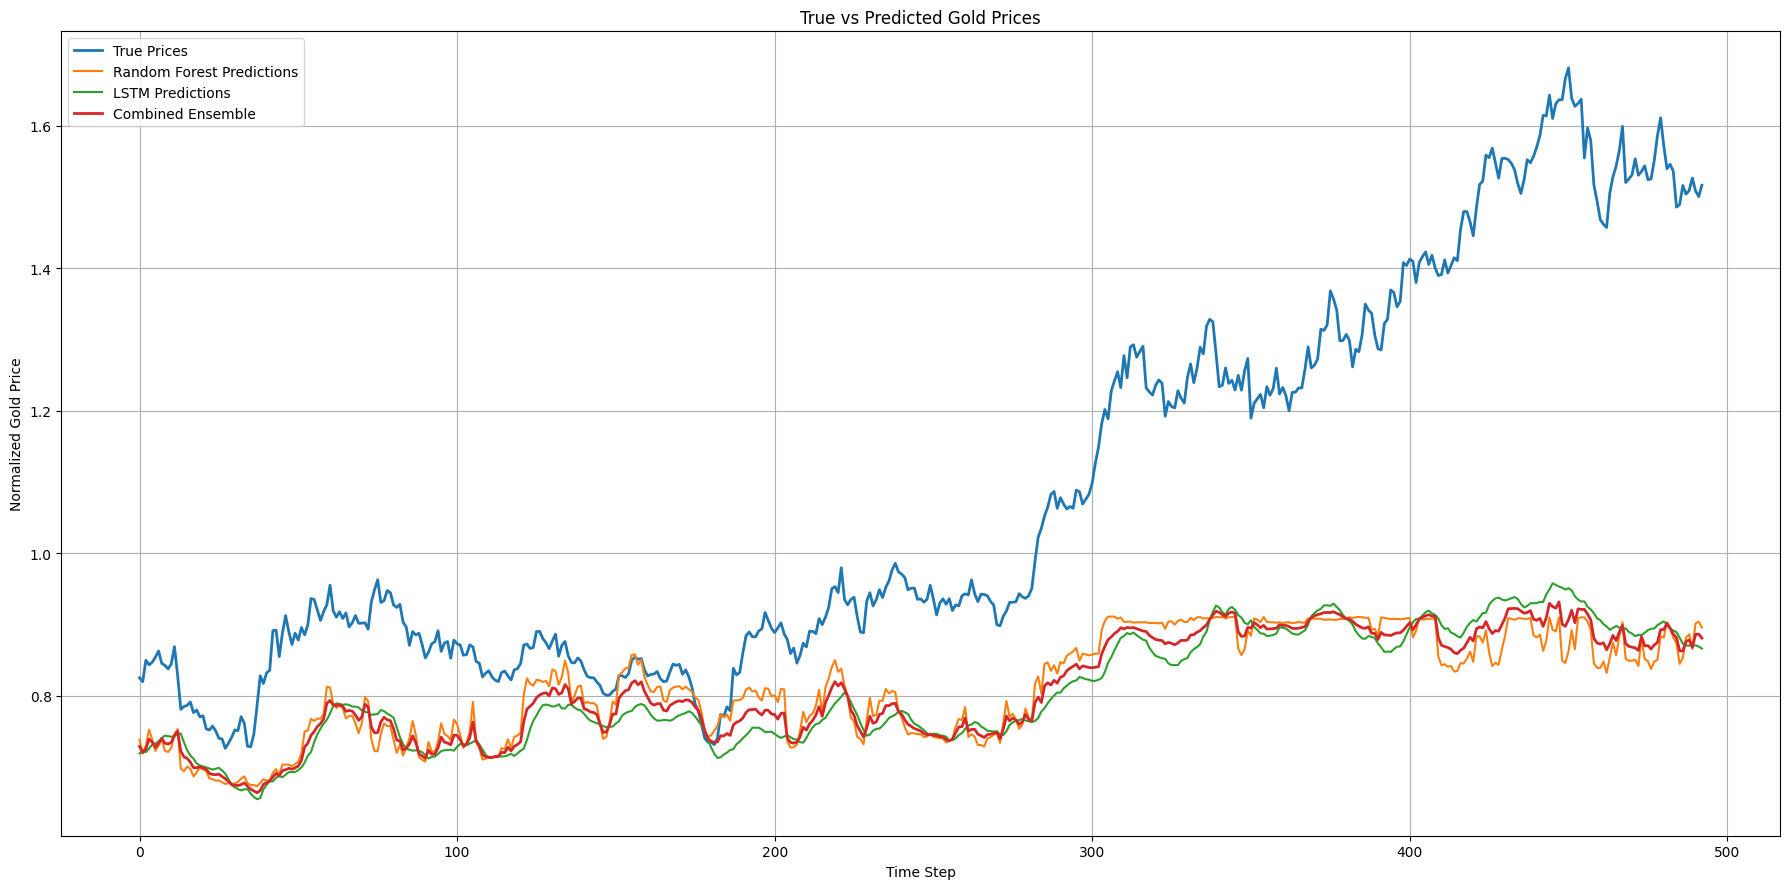

In [32]:
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='True Prices', linewidth=2)
plt.plot(rf_preds, label='Random Forest Predictions')
plt.plot(lstm_preds, label='LSTM Predictions')
plt.plot(combined_preds, label='Combined Ensemble', linewidth=2)
plt.title('True vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
#--- removing the meta model

c:\Users\User\dev\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


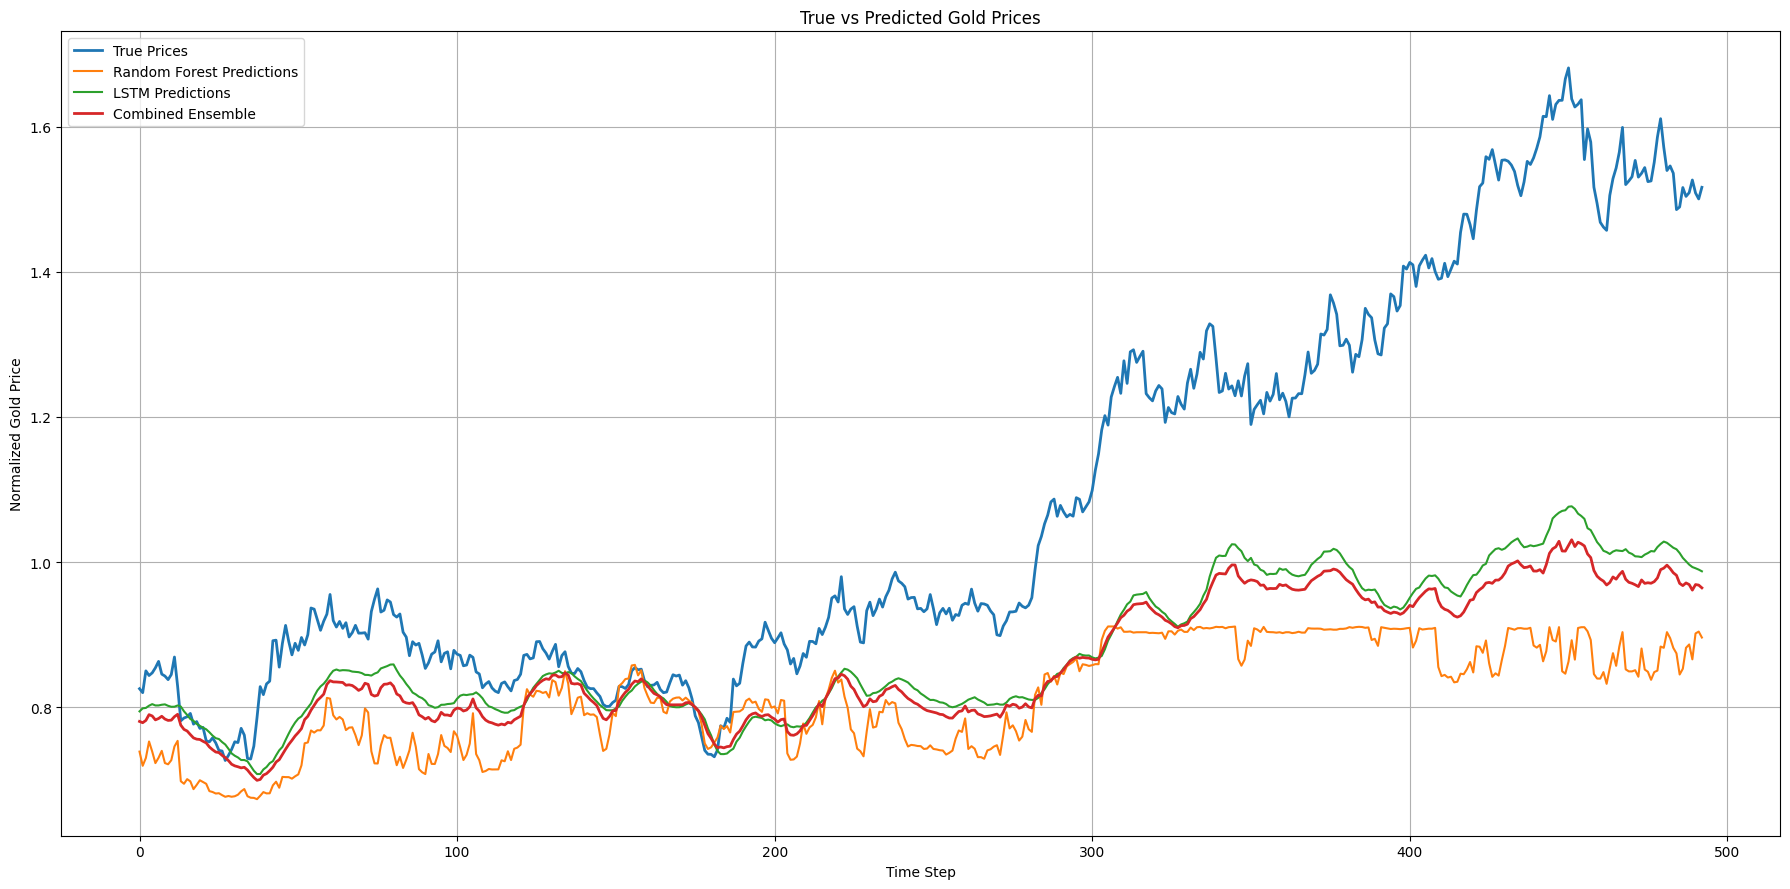

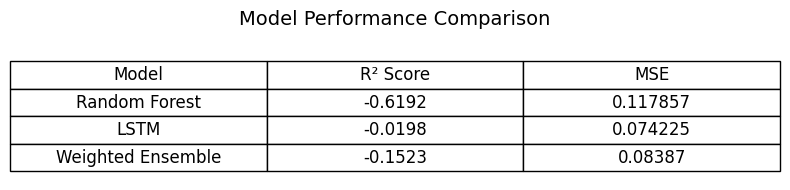

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# --- Load & Prepare Data ---
df = pd.read_csv(r'C:\Users\User\dev\training_model\dataset\modified_financial_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.rename(columns={"^GSPC": "SPX", "EURUSD=X": "EUR/USD"}, inplace=True)

features = ['SPX', 'USO', 'SLV', 'EUR/USD']
target = 'GLD'

# --- Train-Test Split (Time-aware) ---
split_index = int(len(df) * 0.8)
train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]

# --- Scaling ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_test = scaler_X.transform(test_df[features])

y_train = scaler_y.fit_transform(train_df[[target]])
y_test = scaler_y.transform(test_df[[target]])

# --- Random Forest Model ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
rf_preds = rf.predict(X_test)

# --- LSTM Sequence Creator ---
def create_sequences(df_seq, features, target_col, n_steps, scaler_X, scaler_y):
    X_scaled = scaler_X.transform(df_seq[features])
    y_scaled = scaler_y.transform(df_seq[[target_col]])

    X_seq, y_seq = [], []
    for i in range(n_steps, len(df_seq)):
        X_seq.append(X_scaled[i - n_steps:i])
        y_seq.append(y_scaled[i])
    return np.array(X_seq), np.array(y_seq)

# --- LSTM Data ---
n_steps = 10
X_lstm_train, y_lstm_train = create_sequences(train_df, features, target, n_steps, scaler_X, scaler_y)
X_lstm_test, y_lstm_test = create_sequences(test_df, features, target, n_steps, scaler_X, scaler_y)

# --- LSTM Model ---
model_lstm = Sequential([
    LSTM(50, input_shape=(n_steps, len(features))),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=16, verbose=0)

lstm_preds = model_lstm.predict(X_lstm_test).ravel()

# --- Align Predictions ---
min_len = min(len(rf_preds), len(lstm_preds))
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]
y_true = y_test[-min_len:].ravel()

# --- Weighted Ensemble ---
combined_preds = 0.25 * rf_preds + 0.75 * lstm_preds

# --- Evaluation Function ---
def evaluate_model(name, y_true, preds):
    return {
        'Model': name,
        'R² Score': round(r2_score(y_true, preds), 4),
        'MSE': round(mean_squared_error(y_true, preds), 6)
    }

# --- Collect Metrics ---
metrics = [
    evaluate_model("Random Forest", y_true, rf_preds),
    evaluate_model("LSTM", y_true, lstm_preds),
    evaluate_model("Weighted Ensemble", y_true, combined_preds)
]

# --- Plot Results ---
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='True Prices', linewidth=2)
plt.plot(rf_preds, label='Random Forest Predictions')
plt.plot(lstm_preds, label='LSTM Predictions')
plt.plot(combined_preds, label='Combined Ensemble', linewidth=2)
plt.title('True vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Metrics as Table ---
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table_data = [(m['Model'], m['R² Score'], m['MSE']) for m in metrics]
table = ax.table(cellText=table_data, colLabels=["Model", "R² Score", "MSE"],
                 cellLoc='center', loc='center')
table.scale(1, 2)
table.set_fontsize(12)
plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [35]:
#--- using xgboost as stacking model

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


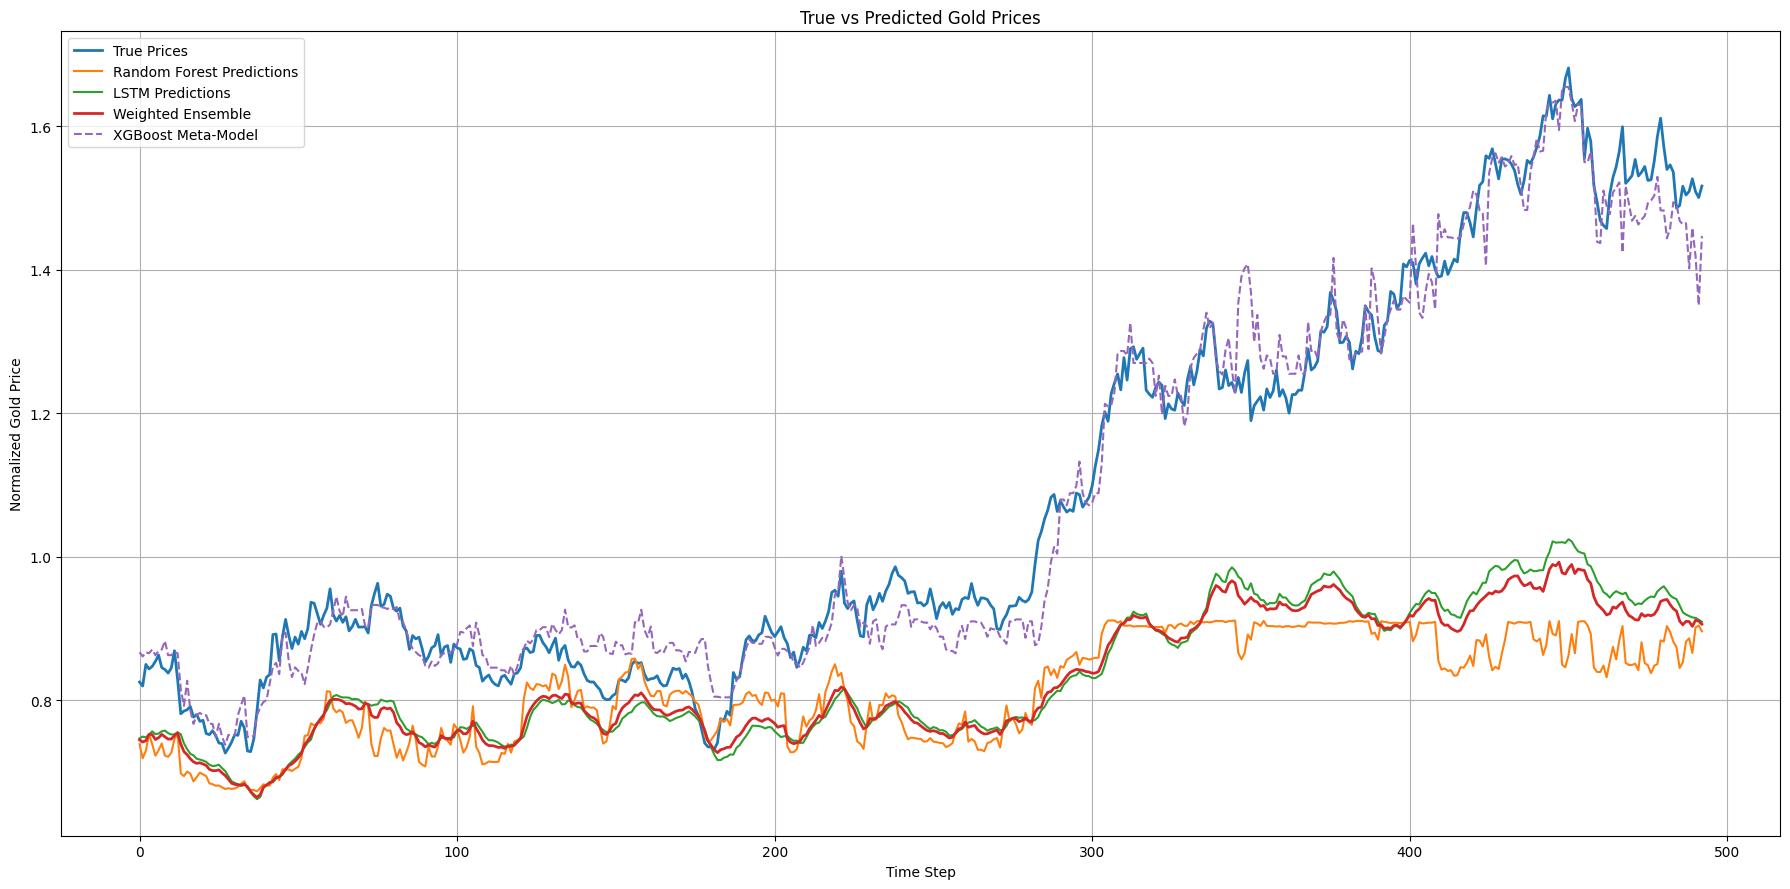

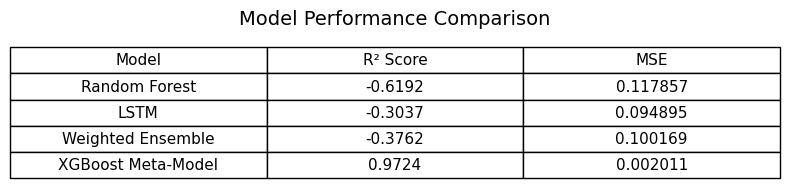

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# --- Load & Prepare Data ---
df = pd.read_csv(r'C:\Users\User\dev\training_model\dataset\modified_financial_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.rename(columns={"^GSPC": "SPX", "EURUSD=X": "EUR/USD"}, inplace=True)

features = ['SPX', 'USO', 'SLV', 'EUR/USD']
target = 'GLD'

# --- Train-Test Split (Time-aware) ---
split_index = int(len(df) * 0.8)
train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]

# --- Scaling ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_test = scaler_X.transform(test_df[features])
y_train = scaler_y.fit_transform(train_df[[target]])
y_test = scaler_y.transform(test_df[[target]])

# --- Random Forest Model ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
rf_preds = rf.predict(X_test)

# --- LSTM Sequence Creator ---
def create_sequences(df_seq, features, target_col, n_steps, scaler_X, scaler_y):
    X_scaled = scaler_X.transform(df_seq[features])
    y_scaled = scaler_y.transform(df_seq[[target_col]])

    X_seq, y_seq = [], []
    for i in range(n_steps, len(df_seq)):
        X_seq.append(X_scaled[i - n_steps:i])
        y_seq.append(y_scaled[i])
    return np.array(X_seq), np.array(y_seq)

# --- LSTM Data ---
n_steps = 10
X_lstm_train, y_lstm_train = create_sequences(train_df, features, target, n_steps, scaler_X, scaler_y)
X_lstm_test, y_lstm_test = create_sequences(test_df, features, target, n_steps, scaler_X, scaler_y)

# --- LSTM Model ---
model_lstm = Sequential([
    LSTM(50, input_shape=(n_steps, len(features))),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=16, verbose=0)

lstm_preds = model_lstm.predict(X_lstm_test).ravel()

# --- Align Predictions ---
min_len = min(len(rf_preds), len(lstm_preds), len(y_test))
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]
y_true = y_test[-min_len:].ravel()

# --- XGBoost Meta-Model ---
meta_X = np.column_stack((rf_preds, lstm_preds))
meta_y = y_true

meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
meta_model.fit(meta_X, meta_y)
xgb_preds = meta_model.predict(meta_X)

# --- Weighted Ensemble ---
combined_preds = 0.25 * rf_preds + 0.75 * lstm_preds

# --- Evaluation Function ---
def evaluate_model(name, y_true, preds):
    return {
        'Model': name,
        'R² Score': round(r2_score(y_true, preds), 4),
        'MSE': round(mean_squared_error(y_true, preds), 6)
    }

# --- Collect Metrics ---
metrics = [
    evaluate_model("Random Forest", y_true, rf_preds),
    evaluate_model("LSTM", y_true, lstm_preds),
    evaluate_model("Weighted Ensemble", y_true, combined_preds),
    evaluate_model("XGBoost Meta-Model", y_true, xgb_preds)
]

# --- Plot Results ---
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='True Prices', linewidth=2)
plt.plot(rf_preds, label='Random Forest Predictions')
plt.plot(lstm_preds, label='LSTM Predictions')
plt.plot(combined_preds, label='Weighted Ensemble', linewidth=2)
plt.plot(xgb_preds, label='XGBoost Meta-Model', linestyle='--')
plt.title('True vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Metrics as Table ---
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table_data = [(m['Model'], m['R² Score'], m['MSE']) for m in metrics]
table = ax.table(cellText=table_data, colLabels=["Model", "R² Score", "MSE"],
                 cellLoc='center', loc='center')
table.scale(1, 2)
table.set_fontsize(12)
plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.tight_layout()
plt.show()
